<a href="https://www.kaggle.com/code/jvinarek/czech-pastries-classifier?scriptVersionId=122644806" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# About

The notebook contains Czech pastries classifier. It is based on the fast ai course notebook https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data

# Download images

In [1]:
!pip install -Uqq fastai duckduckgo_search

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('houska pečivo', max_images=1)
urls[0]

Searching for 'houska pečivo'


'https://eshop.rancherskespeciality.cz/fotky101916/fotos/P_11802_1.JPG'

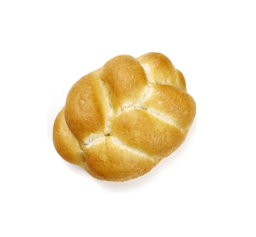

In [4]:
from fastdownload import download_url
dest = 'houska.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'rohlík'


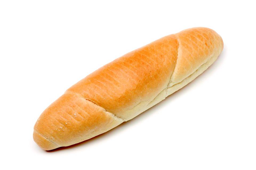

In [5]:
download_url(search_images('rohlík', max_images=1)[0], 'rohlik.jpg', show_progress=False)
Image.open('rohlik.jpg').to_thumb(256,256)

Searching for 'chléb'


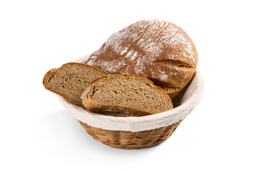

In [6]:
download_url(search_images('chléb', max_images=1)[0], 'chleba.jpg', show_progress=False)
Image.open('chleba.jpg').to_thumb(256,256)

Searching for 'koláč'


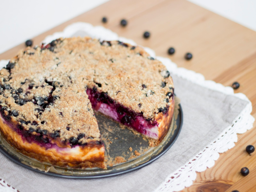

In [7]:
download_url(search_images('koláč', max_images=1)[0], 'kolac.jpg', show_progress=False)
Image.open('kolac.jpg').to_thumb(256,256)

Searching for 'šáteček pečivo'


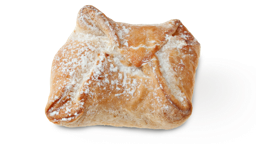

In [8]:
download_url(search_images('šáteček pečivo', max_images=1)[0], 'satecek.jpg', show_progress=False)
Image.open('satecek.jpg').to_thumb(256,256)

Searching for 'vánočka'


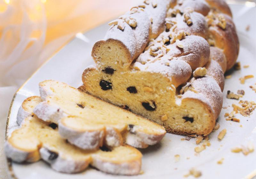

In [9]:
download_url(search_images('vánočka', max_images=1)[0], 'vanocka.jpg', show_progress=False)
Image.open('vanocka.jpg').to_thumb(256,256)

In [10]:
searches = 'houska pečivo', 'rohlík', 'chléb', 'koláč', 'šáteček pečivo', 'vánočka'
path = Path('pastry_classifier')
from time import sleep
from unidecode import unidecode

for search in searches:
    o = unidecode(search).split()[0]
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(search, max_images=200))
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'houska pečivo'


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:980: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Searching for 'rohlík'


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:980: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Searching for 'chléb'
Searching for 'koláč'
Searching for 'šáteček pečivo'


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:980: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:980: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Searching for 'vánočka'


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:980: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

23

# Train model

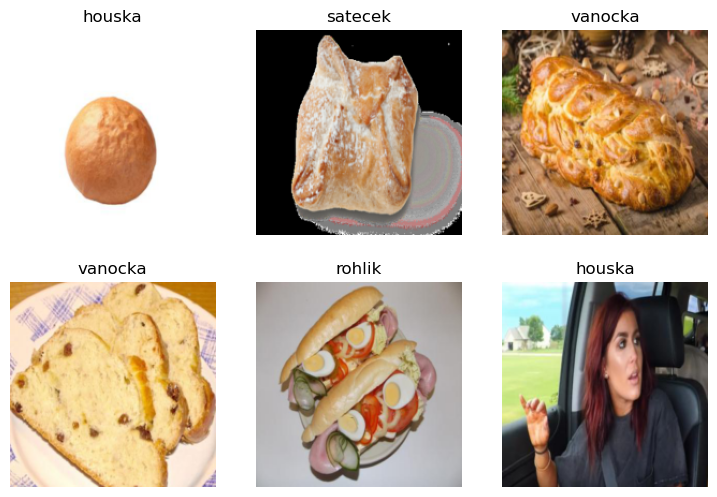

In [12]:
pastry = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')],
)

dls = pastry.dataloaders(path, bs=32)

dls.show_batch(max_n=6)

## Data augmentation

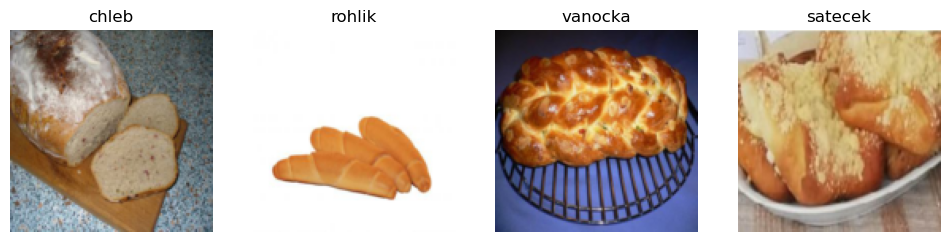

In [13]:
(
    pastry.new(item_tfms=Resize(128, ResizeMethod.Squish))
    .dataloaders(path).valid.show_batch(max_n=4, nrows=1)
)

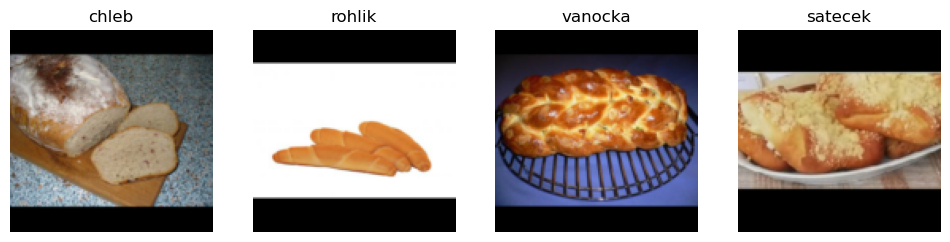

In [14]:
(
    pastry.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
    .dataloaders(path).valid.show_batch(max_n=4, nrows=1)
)

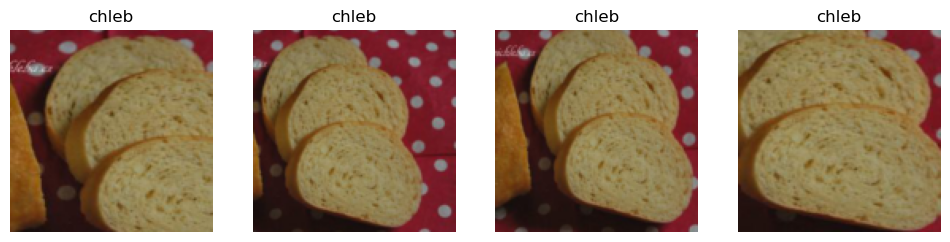

In [15]:
(
    pastry.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
    .dataloaders(path).train.show_batch(max_n=4, nrows=1, unique=True)
)

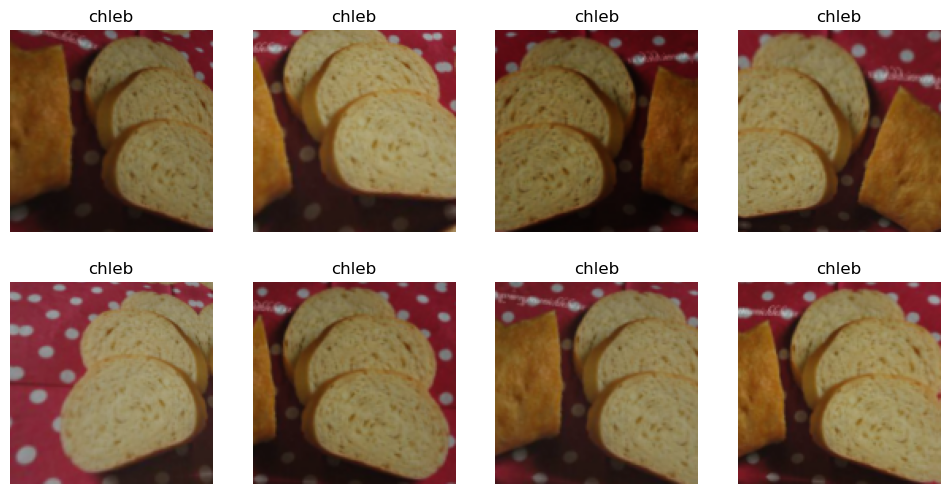

In [16]:
(
    pastry.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
    .dataloaders(path).train.show_batch(max_n=8, nrows=2, unique=True)
)

## Model fine tuning

In [17]:
dls = pastry.dataloaders(path, bs=32)
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.280943,1.077636,0.330233,00:10


epoch,train_loss,valid_loss,error_rate,time
0,1.271279,1.036521,0.353488,00:07
1,1.071217,1.010795,0.316279,00:06
2,0.845138,0.896524,0.265116,00:07
3,0.680118,0.895787,0.265116,00:07


In [18]:
pastry_kind,_,probs = learn.predict('rohlik.jpg')
print(f"This is a: {pastry_kind}.")

categories = learn.dls.vocab
print(dict(zip(categories, map(float, probs))))

This is a: rohlik.
{'chleb': 6.762420980521711e-06, 'houska': 2.4743517315073404e-06, 'kolac': 2.185262415466127e-09, 'rohlik': 0.999987006187439, 'satecek': 3.3070753033825895e-06, 'vanocka': 4.1394676486561366e-07}


## Data cleaning

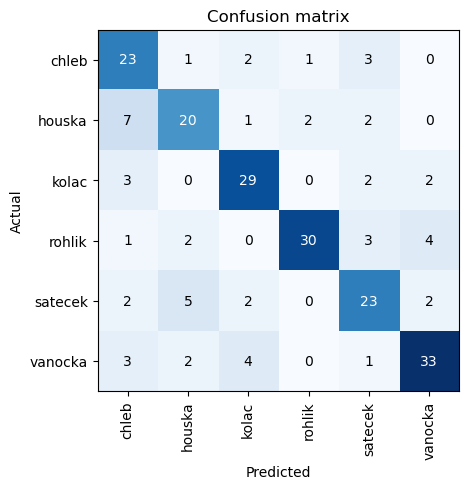

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

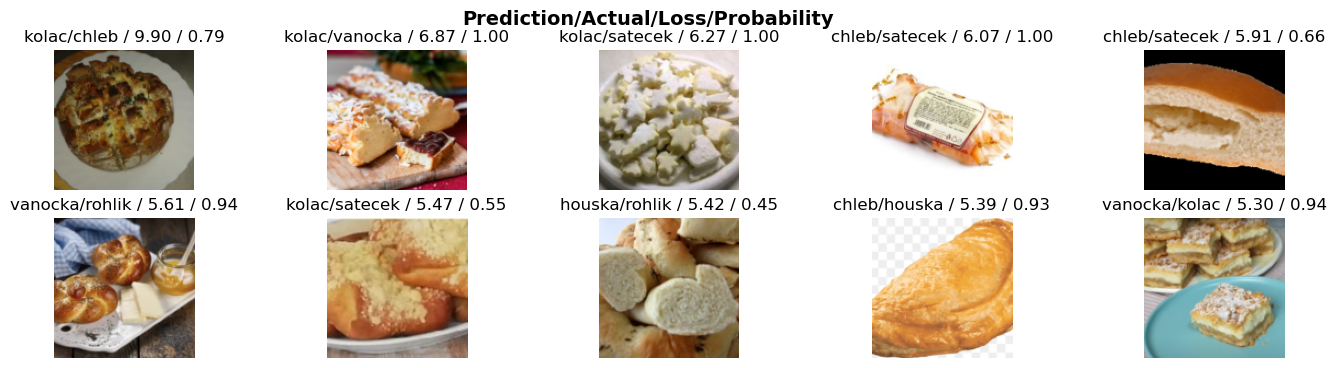

In [20]:
interp.plot_top_losses(10, nrows=2, figsize=(17,4))

In [21]:
from fastai.vision.widgets import ImageClassifierCleaner

cleaner = ImageClassifierCleaner(learn)
cleaner

In [24]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [36]:
pastry = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')],
    batch_tfms=aug_transforms(),
)

dls = pastry.dataloaders(path, bs=32)

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,2.059417,1.086298,0.320930,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.981789,0.854821,0.269767,00:07
1,0.793074,0.748231,0.209302,00:07
2,0.670059,0.857163,0.200000,00:07
3,0.507391,0.829594,0.218605,00:07
4,0.406552,0.868158,0.186047,00:08
5,0.313588,0.818991,0.195349,00:07
6,0.244926,0.757365,0.176744,00:07
7,0.195794,0.770183,0.176744,00:07
8,0.171606,0.743751,0.167442,00:08
9,0.142598,0.769002,0.172093,00:07


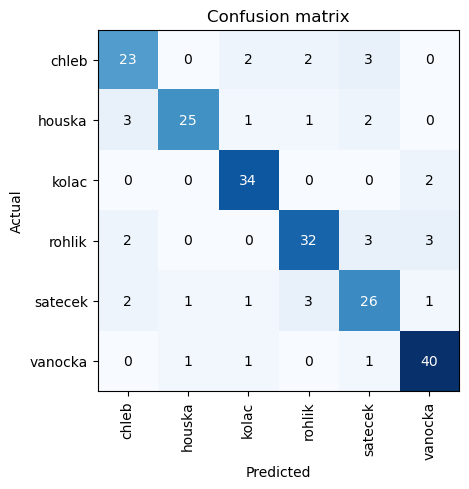

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Testing with uploaded data

In [31]:
import ipywidgets as widgets

# Create the widget
uploader = widgets.FileUpload(
    accept='.jpg',   # The type of files to accept
    multiple=False    # Whether to allow to upload multiple files or not
)

# Display the widget
display(uploader)

FileUpload(value={}, accept='.jpg', description='Upload')

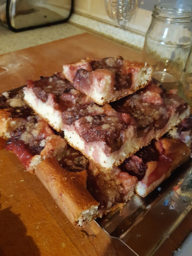

In [37]:
img = PILImage.create(uploader.data[0])
img.to_thumb(256,256)

In [38]:
img.save('upload_test.jpg')

In [39]:
pastry_kind,_,probs = learn.predict('upload_test.jpg')
print(f"This is a: {pastry_kind}.")

categories = learn.dls.vocab
print(dict(zip(categories, map(float, probs))))

This is a: kolac.
{'chleb': 0.00012419730774126947, 'houska': 0.001032358850352466, 'kolac': 0.835772693157196, 'rohlik': 0.00024720063083805144, 'satecek': 8.862662980391178e-06, 'vanocka': 0.16281475126743317}


# Export model

In [41]:
learn.export('model.pkl')